In [22]:
import random
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Categorical
from torch.utils.data import DataLoader
from transformers.optimization import (
    AdamW,
    get_constant_schedule_with_warmup,
)
from IPython.display import clear_output

In [23]:
SEED = 0
BATCH_SIZE = 256
LR = 0.002 * BATCH_SIZE / 1024
EPOCHS = 20
WARMUP_EPOCHS = 5
CLIP = 0.2
TARGET_KL = 0.015
# TARGET_KL = 999
GAMMA = 0.999
ENT_COEF = 0.01
GRAD_NORM = False
OBS_NORM = False
NUM_ROLLOUT = 1
GROUP_SIZE = 2
# set device
use_cuda = torch.cuda.is_available()
print("cuda:", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

cuda: False


In [24]:
class ActorCriticNet(nn.Module):
    def __init__(self, obs_space, action_space, use_obs_norm=True):
        super().__init__()
        h = 64
        self.use_obs_norm = use_obs_norm
        self.obs_space = obs_space
        self.obs_norms = nn.ModuleList([nn.BatchNorm1d(1, momentum=None, affine=False) for _ in range(obs_space)])
        self.pol = nn.Sequential(
            nn.Linear(obs_space, h, bias=True),
            nn.Tanh(),
            nn.Linear(h, action_space, bias=True),
        )
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        if self.use_obs_norm:
            norm_x = []
            for norm, obs in zip(self.obs_norms, x.chunk(chunks=self.obs_space, dim=1)):
                norm_x.append(norm(obs))
            x = torch.concat(norm_x, dim=1)
        logit = self.pol(x).reshape(x.shape[0], -1)
        log_p = self.log_softmax(logit)
        return log_p

In [25]:
losses = []
mean_losses = []


def learn(net, old_net, optimizer, scheduler, train_memory):
    net.train()
    old_net.eval()

    for _ in range(EPOCHS):
        dataloader = DataLoader(train_memory, shuffle=True, batch_size=BATCH_SIZE, pin_memory=use_cuda)
        for s, a, _, adv in dataloader:
            s_batch = s.to(device).float()
            a_batch = a.to(device).long()
            adv_batch = adv.to(device).float()
            batch_size = s_batch.shape[0]
            with torch.no_grad():
                log_p_batch_old = old_net(s_batch)
                log_p_acting_old = log_p_batch_old[range(batch_size), a_batch]

            log_p_batch = net(s_batch)
            log_p_acting = log_p_batch[range(batch_size), a_batch]
            p_ratio = (log_p_acting - log_p_acting_old).exp()
            p_ratio_clip = torch.clamp(p_ratio, 1 - CLIP, 1 + CLIP)
            p_loss_clip = torch.min(p_ratio * adv_batch, p_ratio_clip * adv_batch).mean()
            entropy = -(log_p_batch.exp() * log_p_batch).sum(dim=1).mean()
            p_loss = p_loss_clip + ENT_COEF * entropy

            # approx_kl를 계산하되, 그래프에 포함되지 않도록 함
            with torch.no_grad():
                approx_kl = (log_p_batch_old - log_p_batch).mean().item()

            # approx_kl가 임계치를 초과하면 p_loss의 gradient 전파를 차단
            if approx_kl > TARGET_KL:
                p_loss_update = p_loss.detach()
                loss = -p_loss_update
            else:
                p_loss_update = p_loss
                # 최종 loss 구성
                loss = -p_loss_update

                # optimizer 업데이트
                optimizer.zero_grad()
                loss.backward()

                if GRAD_NORM:
                    nn.utils.clip_grad_norm_(net.parameters(), max_norm=0.5)
                optimizer.step()
                scheduler.step()

            losses.append(loss.item())
            mean_losses.append(np.mean(losses[-200:]))

    train_memory.clear()


def get_action(obs, old_net):
    old_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        log_p = old_net(state)
        m = Categorical(log_p.exp())
        action = m.sample()
    return action.item()


def compute_return(rewards, roll_memory):
    dis_r = np.array([GAMMA ** (i) * r for i, r in enumerate(rewards)], dtype=np.float32)
    for i, data in enumerate(roll_memory):
        ret = sum(dis_r[i:] / GAMMA ** (i))
        data.append(ret)
        assert len(data) == 3
    return roll_memory


def compute_advantage(group_memory):
    rets = []
    for data in group_memory:
        rets.append(data[2])

    rets_mean = np.mean(rets)
    rets_std = np.std(rets) + 1e-8
    for i, data in enumerate(group_memory):
        adv = (rets[i] - rets_mean) / rets_std
        data.append(adv)
        assert len(data) == 4, f"{len(data)}"
    return group_memory

In [26]:
def plot(ep_rewards, reward_eval, n_eval):
    clear_output(True)
    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.plot(ep_rewards, alpha=0.5)
    plt.subplot(121)
    plt.plot(reward_eval)
    plt.title(f"Reward: " f"{reward_eval[-1]}")
    plt.subplot(122)
    plt.plot(losses, alpha=0.5)
    plt.subplot(122)
    plt.plot(mean_losses)
    plt.title(f"Loss: " f"{np.mean(list(reversed(losses))[: n_eval]):.4f}")
    plt.show()

In [27]:
# make an environment
# env = gym.make("CartPole-v0")
env = gym.make("CartPole-v1")
# env = gym.make("MountainCar-v0")
# env = gym.make("LunarLander-v2")

obs_space = env.observation_space.shape[0]
action_space = env.action_space.n
print(obs_space)
print(action_space)
print(env.spec.reward_threshold)
print(env.spec.max_episode_steps)

4
2
475.0
500


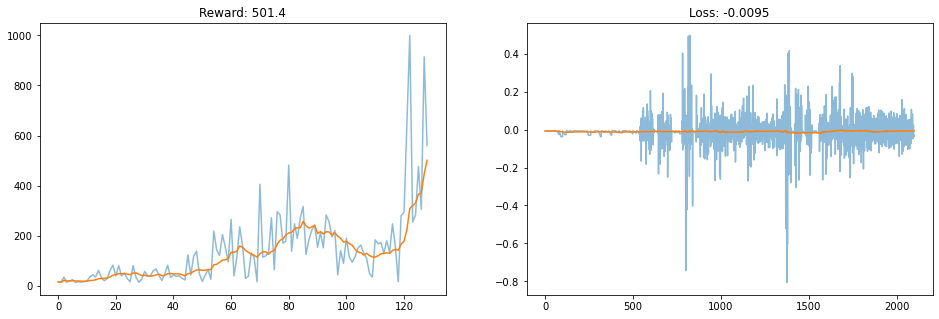


CartPole-v1 is solved!  65 Episode in 18198 steps


In [28]:
max_ep_len = 1000
total_epochs = env.spec.max_episode_steps * NUM_ROLLOUT // BATCH_SIZE
episode_counter = 1  # 전체 에피소드 카운터
steps = 0  # 전체 스텝 카운터
n_episodes = 100000
n_eval = 10

# --- 네트워크, 옵티마이저, 스케줄러 생성 (이전 코드와 동일) ---
net = ActorCriticNet(obs_space, action_space, OBS_NORM).to(device)
old_net = deepcopy(net)
no_decay = ["bias"]
grouped_parameters = [
    {"params": [p for n, p in net.named_parameters() if not any(nd in n for nd in no_decay)], "weight_decay": 0.01},
    {"params": [p for n, p in net.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
]
optimizer = torch.optim.AdamW(grouped_parameters, lr=LR, eps=1e-8)
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=total_epochs * EPOCHS * WARMUP_EPOCHS)

# --- 메모리 변수 ---
train_memory = []  # 글로벌로 누적할 학습 메모리 (learn() 함수 내부에서 clear됨)
ep_rewards = []  # 에피소드 보상 기록
reward_eval = []  # 최근 n_eval 에피소드의 평균 보상 기록
solved = False

while episode_counter <= n_episodes:
    group_memory = []
    for g in range(GROUP_SIZE):
        # 에피소드별로 롤아웃 관련 리스트 초기화
        roll_memory = []  # 각 transition([obs, action]) 저장
        rewards = []  # 각 timestep의 reward 저장
        done = False
        timeout = False
        ep_reward = 0
        ep_steps = 0
        obs, _ = env.reset(seed=episode_counter)
        while not done:
            action = get_action(obs, old_net)
            _obs, reward, done, _, _ = env.step(action)

            # 현재 transition 저장
            roll_memory.append([obs, action])
            rewards.append(reward)

            obs = _obs
            steps += 1
            ep_steps += 1
            ep_reward += reward

            timeout = ep_steps >= max_ep_len

            if done or timeout:
                group_memory.extend(compute_return(rewards, roll_memory))
                # rewards.clear()
                # roll_memory.clear()
                # print(g, len(rewards), timeout)

                # === 에피소드 종료 후 로깅 및 목표 보상 달성 체크 ===
                ep_rewards.append(ep_reward)
                # 최신 n_eval 에피소드의 평균 보상 계산
                current_avg = np.mean(list(reversed(ep_rewards))[:n_eval])
                reward_eval.append(np.round(current_avg, 2))
                plot(ep_rewards, reward_eval, n_eval)

                if timeout:
                    break
                # 목표 보상 달성 여부 확인 (에피소드 수가 n_eval 이상일 때)
                if len(ep_rewards) >= n_eval and reward_eval[-1] >= env.spec.reward_threshold:
                    print("\n{} is solved! {:3} Episode in {:3} steps".format(env.spec.id, episode_counter, steps))
                    torch.save(
                        net.state_dict(),
                        f"./test/saved_models/{env.spec.id}_ep{episode_counter}_clear_model_ppo_st.pt",
                    )
                    env.close()
                    solved = True
                    break
            if solved:
                break
        if solved:
            break
    if solved:
        break
    if episode_counter >= n_episodes:
        break

    train_memory.extend(compute_advantage(group_memory))
    # group_memory.clear()
    # 일정 에피소드마다 학습 진행
    if episode_counter % NUM_ROLLOUT == 0:
        learn(net, old_net, optimizer, scheduler, train_memory)
        old_net.load_state_dict(net.state_dict())
    episode_counter += 1

In [29]:
[("CartPole-v0", 186, 3, 4), ("CartPole-v1", 277, 3, 4), ("MountainCar-v0", None), ("LunarLander-v2", None)]

[('CartPole-v0', 186, 3, 4),
 ('CartPole-v1', 277, 3, 4),
 ('MountainCar-v0', None),
 ('LunarLander-v2', None)]